In [48]:
import numpy as np
from sklearn.preprocessing import StandardScaler
!wget -nc http://www.fredjo.com/files/ihdp_npci_1-100.train.npz
!wget -nc http://www.fredjo.com/files/ihdp_npci_1-100.test.npz 
 
def load_IHDP_data(training_data,testing_data,i=7):
    with open(training_data,'rb') as trf, open(testing_data,'rb') as tef:
        train_data=np.load(trf); test_data=np.load(tef)
        y=np.concatenate(   (train_data['yf'][:,i],   test_data['yf'][:,i])).astype('float32') #most GPUs only compute 32-bit floats
        t=np.concatenate(   (train_data['t'][:,i],    test_data['t'][:,i])).astype('float32')
        x=np.concatenate(   (train_data['x'][:,:,i],  test_data['x'][:,:,i]),axis=0).astype('float32')
        mu_0=np.concatenate((train_data['mu0'][:,i],  test_data['mu0'][:,i])).astype('float32')
        mu_1=np.concatenate((train_data['mu1'][:,i],  test_data['mu1'][:,i])).astype('float32')
 
        data={'x':x,'t':t,'y':y,'t':t,'mu_0':mu_0,'mu_1':mu_1}
        data['t']=data['t'].reshape(-1,1) #we're just padding one dimensional vectors with an additional dimension 
        data['y']=data['y'].reshape(-1,1)
        #rescaling y between 0 and 1 often makes training of DL regressors easier
        data['y_scaler'] = StandardScaler().fit(data['y'])
        data['ys'] = data['y_scaler'].transform(data['y'])
 
    return data
 
data =load_IHDP_data(training_data='./ihdp_npci_1-100.train.npz',testing_data='./ihdp_npci_1-100.test.npz')

X,y, t = data['x'], data['y'], data['t']

File ‘ihdp_npci_1-100.train.npz’ already there; not retrieving.

File ‘ihdp_npci_1-100.test.npz’ already there; not retrieving.



In [83]:
import pandas as pd
data = pd.read_csv("data_processed_arnaud.csv")
data.set_index("Unnamed: 0", drop=True, inplace=True)
data.index.name = None
data

,bicarbonate,wbc,lactate_cat,creatinine,sodium,temperature,potassium,glucose,hospital_expire_flag,treatment,chf,esrd,chf.esrd,sepsis.only
0,23.0,13.3,0,0.7,145.0,38.40,2.8,116.0,0,0.552022,0,0,0,1
1,28.0,17.5,0,0.8,142.0,37.06,4.2,114.0,0,0.427077,0,0,0,1
2,23.0,15.1,1,1.8,137.0,37.28,4.9,115.0,0,0.610415,0,0,0,1
3,17.0,27.5,0,1.2,143.0,36.56,3.4,103.0,0,0.377865,0,0,0,1
4,28.0,NaN,0,0.7,134.0,35.94,4.1,135.0,0,0.482702,0,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
14793,24.0,5.5,0,1.3,136.0,37.72,5.9,190.0,0,0.384388,0,0,0,1
14794,22.0,3.7,1,0.8,145.0,36.72,3.5,81.0,1,0.000000,0,0,0,1
14795,26.0,7.3,5,1.8,138.0,36.44,4.4,165.0,1,0.306615,1,0,0,0
14796,14.0,15.0,1,4.8,140.0,36.33,5.5,224.0,0,0.275914,1,1,1,0


In [84]:
data = data.dropna()

In [95]:
covariates_cols = data.columns[:8]
outcome = "hospital_expire_flag"
treatment = "treatment"

X = data[covariates_cols].to_numpy(dtype="float32")
t = data[treatment].to_numpy(dtype="float32").reshape(-1,1)
y = data[outcome].to_numpy(dtype="float32").reshape(-1,1)


In [96]:
n_treatment = 10
t = (t*(n_treatment-1)).astype("int")

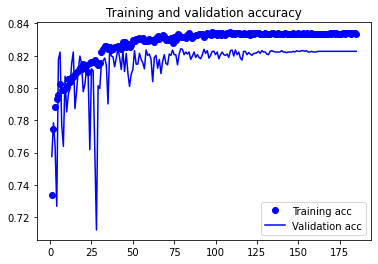

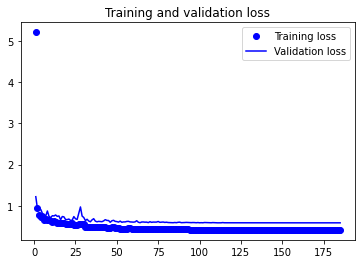

In [121]:
from tarNET import tarNET

model = tarNET(output_dim=1, n_treatments=10)


import tensorflow as tf
import numpy as np
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, TerminateOnNaN
from tensorflow.keras.optimizers import SGD, Adam

from IPython.display import clear_output

val_split = 0.2
batch_size = 64
verbose = 1
i = 0
tf.random.set_seed(i)
np.random.seed(i)

sgd_callbacks = [
    TerminateOnNaN(),
    EarlyStopping(monitor="val_loss", patience=40, min_delta=0.0),
    # 40 is Shi's recommendation for this dataset, but you should tune for your data
    ReduceLROnPlateau(
        monitor="loss",
        factor=0.5,
        patience=5,
        verbose=verbose,
        mode="auto",
        min_delta=0.0,
        cooldown=0,
        min_lr=0,
    ),
]
# optimzier hyperparameters
sgd_lr = 1e-5
momentum = 0.9
loss = (
    tf.keras.losses.BinaryCrossentropy(from_logits=True)
)


model.compile(
    optimizer=SGD(learning_rate=sgd_lr, momentum=momentum, nesterov=True),
    loss=loss,
    metrics=tf.keras.metrics.BinaryAccuracy(),
)

history = model.fit(
    x=[X, t],  # [data["x"], data["t"]],
    y=y,  # data['y'],
    callbacks=sgd_callbacks,
    validation_split=val_split,
    epochs=1000,
    batch_size=batch_size,
    verbose=verbose,
)

clear_output()

acc = history.history['binary_accuracy']
val_acc = history.history['val_binary_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

import matplotlib.pyplot as plt

epochs = range(1, len(acc) + 1)

plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()

plt.figure()

plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

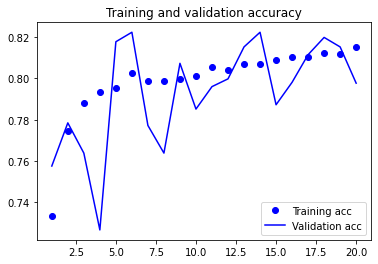

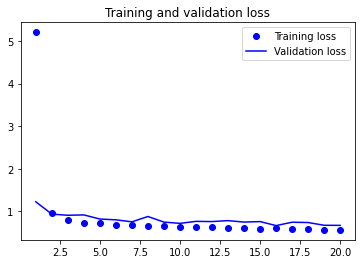

In [120]:
acc = history.history['binary_accuracy']
val_acc = history.history['val_binary_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

import matplotlib.pyplot as plt

epochs = range(1, len(acc) + 1)

plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()

plt.figure()

plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()